## DataSet - Seatle

Questions to be ansewered:

1 - Determine the peak month for visiting Seattle and its relationship with the price.

2 - Investigate how host-provided amenities and neighborhood impact Airbnb prices.

3 - Wath features are more inportant to determine the price of a listing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
from sklearn.model_selection import GridSearchCV
# Suppress all warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_rows', 500)
#pd.set_option("max_columns", None)



## Describing data

In [2]:
df_calendar = pd.read_csv(r'archive_seatle/calendar.csv')
df_listings = pd.read_csv(r'archive_seatle/listings.csv')
df_reviews = pd.read_csv(r'archive_seatle/reviews.csv')

In [3]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [53]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [54]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In this project, we are working with three datasets:

1) df_calendar: Contains information on availability and pricing for listings in Seattle.
2) df_listings: Provides details on the characteristics of each listing.
3) df_reviews: Includes reviews and comments for the listings, which will not be utilized in this project.

In [56]:
df_calendar.rename(columns={'listing_id':'id'},inplace= True) # In the furete this will be a key to we join the listings and calendar data set.

### Data Prep

In [6]:
def transform_price_to_float(df_colum):

    '''
    Receive a price column with dolar sign and return a a float column
    ]
    '''
    df_colum = df_colum.replace({'\$':'',',':''},regex = True).astype(float)
    return df_colum

In [7]:
df_calendar['price'] = transform_price_to_float(df_calendar['price'])
df_calendar['year_month'] = pd.to_datetime(df_calendar['date'], errors='coerce').dt.to_period('M').astype(str)
df_calendar['month'] = pd.to_datetime(df_calendar['date']).dt.month
df_calendar['year'] = pd.to_datetime(df_calendar['date']).dt.year

df_calendar_price = df_calendar[df_calendar.available == 't'].groupby(['year_month'])['price'].mean().reset_index()
df_calendar_count_availablet = df_calendar[df_calendar.available == 't'].groupby(['year_month'])['id'].nunique().reset_index()
#df_calendar_count_total = df_calendar.groupby(['year_month'])['listing_id'].count().reset_index()
#availability_ratio = df_calendar_count_availablef['listing_id']/df_calendar_count_total['listing_id']

In [8]:
def missing_chart(df):
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().mean() * 100

    # Filter columns with missing values greater than 0%
    missing_percentage = missing_percentage[missing_percentage > 0]

    # Plot the missing values percentage
    plt.figure(figsize=(10, 6))
    missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title('Percentage of Missing Values per Column')
    plt.xlabel('Columns')
    plt.ylabel('Percentage of Missing Values (%)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

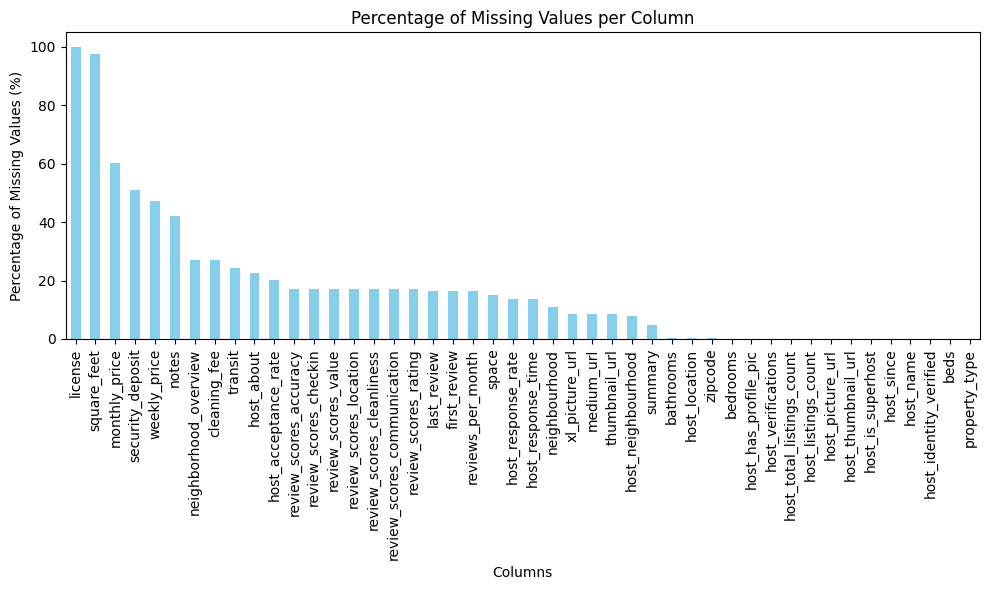

In [9]:
missing_chart(df_listings)

In [10]:
def basic_clean_data(df_toclean,threshold_percentage,text):
    '''
        Function receives data frame and identifys and drop:
            Columns with the unique values
            Columns with na values
            Columns that contains certain text
    '''
    df = df_toclean.copy()
    df_original = df_toclean.copy()

    colums_to_drop = ['street','host_verifications','neighbourhood_cleansed','neighbourhood','notes','host_neighbourhood','name','description','host_name','price',
                      'host_name','host_about','availability_365','first_review','last_review',
                      'host_total_listings_count','city','state','zipcode','market','smart_location','country_code','country','latitude',
                      'longitude','is_location_exact','weekly_price','monthly_price','weekly_price','monthly_price','jurisdiction_names',
                      'host_id','host_location','maximum_nights','calendar_updated','availability_30','availability_60','availability_90',
                      'summary','space','neighborhood_overview','transit','host_since','require_guest_profile_picture','require_guest_phone_verification','host_listings_count','calculated_host_listings_count']
    
    df.drop(columns = colums_to_drop,inplace = True)

    
    non_null_percentage =  df.isnull().mean()*100
    # Select columns with less than the threshold percentage of non-null values
    columns_with_few_values = non_null_percentage[non_null_percentage < (threshold_percentage)].index
    # Filter the DataFrame to keep only the selected columns
    df = df[columns_with_few_values]
        

    df.drop_duplicates(inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    #dropping columns with UrL string
    df = df[df.columns.drop(list(df.filter(regex=text)))]
    #Drop columns that contain just one unique value
    for i in df.columns:
        if len(df[i].unique()) == 1:
            df.drop([i],inplace =True,axis = 1)
    droped_columns = []
    for i in df_original.columns:
        if i not in df.columns:
            droped_columns.append(i)

    return df,droped_columns

In [11]:
df_listings_cleaned = basic_clean_data(df_listings,40,'url')[0]

In [12]:
df_listings_cleaned.cleaning_fee = transform_price_to_float(df_listings_cleaned.cleaning_fee)
df_listings_cleaned.extra_people = transform_price_to_float(df_listings_cleaned.extra_people)


In [13]:
columns_to_transform_01 = [
    'host_is_superhost',
    'instant_bookable',
    'host_has_profile_pic',
    'host_identity_verified']

In [14]:
columns_to_transform_in_dummies = [
    'host_response_time',
    'property_type',
    'cancellation_policy',
    'bed_type',
    'neighbourhood_group_cleansed'
]

In [15]:
df_listings_cleaned['amenities'] = df_listings_cleaned['amenities'].replace({'"':'','{':'','}':''}, regex=True).astype(str)
#df_listings_cleaned['amenities'] = df_listings_cleaned['amenities'].apply(lambda x:x.split(','))
all_features = set()
for features in df_listings_cleaned['amenities'].apply(lambda x:x.split(',')):
    #print(features)
    # Strip any extra spaces around the items
    features_list = [item.strip() for item in features]
    
    # Update the set with unique items from each list
    all_features.update(features_list)

all_features.discard('')

for feature in all_features:
    df_listings_cleaned[feature] = 0

# Update the new columns based on the presence of features
for idx, row in df_listings_cleaned.iterrows():

    amenities_list = df_listings_cleaned.loc[idx, 'amenities'].split(',')
    amenities_list = [item.strip() for item in amenities_list]

    # Update the corresponding binary columns to 1 if the feature is present
    for amenity in all_features:
        #print(amenity)
        if amenity in amenities_list:
            df_listings_cleaned.loc[idx, amenity] = 1


df_listings_cleaned.drop(columns = ['amenities'],inplace = True)

In [16]:
def replace_tf(df, columns):
    """
    Replace 'f' with 0 and 't' with 1 in specified columns of the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to modify.
    columns (list): List of column names where replacements should be made.

    Returns:
    None: The DataFrame is modified in place.
    """
    for column in columns:
        if column in df.columns:
            df[column] = df[column].replace({'f': 0, 't': 1})
    return None

replace_tf(df_listings_cleaned, columns_to_transform_01)


df_listings_cleaned['host_response_rate'] = df_listings_cleaned['host_response_rate'].replace({'%':''},regex = True)
df_listings_cleaned['host_acceptance_rate'] = df_listings_cleaned['host_acceptance_rate'].replace({'%':''},regex = True)



In [17]:
columns_inputer_mean = [
    'host_response_rate',
    'host_acceptance_rate',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'cleaning_fee',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month']

columns_inputer_most_freequent = ['host_response_time' ,'host_is_superhost','host_has_profile_pic','host_identity_verified','property_type']

def aply_inputer(df,strategy_inputer,columns):
    imputer_mean = SimpleImputer(strategy=strategy_inputer)
    # Extract the columns to impute
    df_to_impute = df[columns]
    # Fit and transform the specified columns
    df_imputed = pd.DataFrame(imputer_mean.fit_transform(df_to_impute), columns=columns)
    # Replace the imputed columns in the original DataFrame
    df[columns]= df_imputed
    # Fit the imputer on the DataFrame and transform it
    return None

In [18]:
aply_inputer(df_listings_cleaned,'mean',columns_inputer_mean)
aply_inputer(df_listings_cleaned,'most_frequent',columns_inputer_most_freequent)

In [19]:
columns_to_dummies = ['host_response_time','neighbourhood_group_cleansed','property_type','room_type','bed_type','cancellation_policy']

def transform_to_dummies(df, columns):
    """
    Transform specified columns in the DataFrame into dummy/one-hot encoded variables.

    Parameters:
    df (pd.DataFrame): The DataFrame to modify.
    columns (list): List of column names to be transformed into dummies.

    Returns:
    None
    """
    dummies_dict = {}

    # Loop through each column in the specified columns
    for column in columns:
        # Check if the column exists in the DataFrame
        if column in df.columns:
            # Get dummies for the column
            dummies = pd.get_dummies(df[column], prefix=column).applymap(lambda x: 1 if x > 0 else 0)
            # Concatenate the dummies with the original DataFrame
            df = pd.concat([df, dummies], axis=1)
            dummies_dict[column] = list(dummies.columns)
            # Drop the original column
            #df.drop(columns=column, axis=1, inplace=True)

        else:
            print(f"Column '{column}' not found in DataFrame.")

    return df,dummies_dict

In [20]:
df_listings_cleaned,dummies_dict = transform_to_dummies(df_listings_cleaned,columns_to_dummies)

1 - Determine the peak month for visiting Seattle and its relationship with the price.

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_calendar_price['year_month'], y=df_calendar_price['price'], name="price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = df_calendar_price['year_month'], y=df_calendar_count_availablet['id'], name="Count of not available listings_id"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Correlation between price and availability"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Price", secondary_y=False)
fig.update_yaxes(title_text="Count of not available listings_id", secondary_y=True)

fig.show()

The chart above shows a negative correlation between price and the number of available listings. Additionally, it highlights that the peak season for Seattle occurs in July. Let's now examine the correlation coefficient between these two variables.

In [22]:
corr_coef = df_calendar_price['price'].corr(df_calendar_count_availablet['id'])

print('The correlation coefficient  is {:.2f}'.format(corr_coef))

The correlation coefficient  is -0.78


2 - Investigate how host-provided amenities and neighborhood characteristics impact Airbnb prices.

In [23]:
df_calendar_available = df_calendar[df_calendar.available == 't'].copy()

In [24]:
df_merged = df_calendar_available.merge(df_listings_cleaned,on = ['id'],how='left')

In [25]:
import plotly.express as px

df_merged_groupby = df_merged.groupby(['year_month','neighbourhood_group_cleansed'])['price'].mean().reset_index()
neighborhoods = df_merged_groupby['neighbourhood_group_cleansed'].unique()
# Create line plot
fig = px.line(
    df_merged_groupby,
    x='year_month',
    y='price',
    color='neighbourhood_group_cleansed',
    markers=True,
    title='Average Price Trends by Neighbourhood Group'
)

# Update layout for better visualization
fig.update_layout(
xaxis_title='Year-Month',
    yaxis_title='Average Price',
    legend_title='Neighbourhood Group',
    xaxis_tickmode='array',
    xaxis_tickvals=df_merged_groupby['year_month'].unique(),  # Show all months as ticks
)
# Show the figure
fig.show()

We can see that Downtown, Magnolia, and Queen Anne have the top three average prices for the year.

In [26]:

#sns.heatmap(df_merged[['price']+list(all_features)[:3]], annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


In [27]:
# Set the style of the visualization
def corr_heatmap(List_columns,annot=True):
    sns.set(style="white")

    # Compute the correlation matrix, excluding specific columns
    corr = df_merged[['price'] + List_columns].corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=annot,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # Add titles and labels
    plt.title('Correlation Heatmap')
    plt.show()

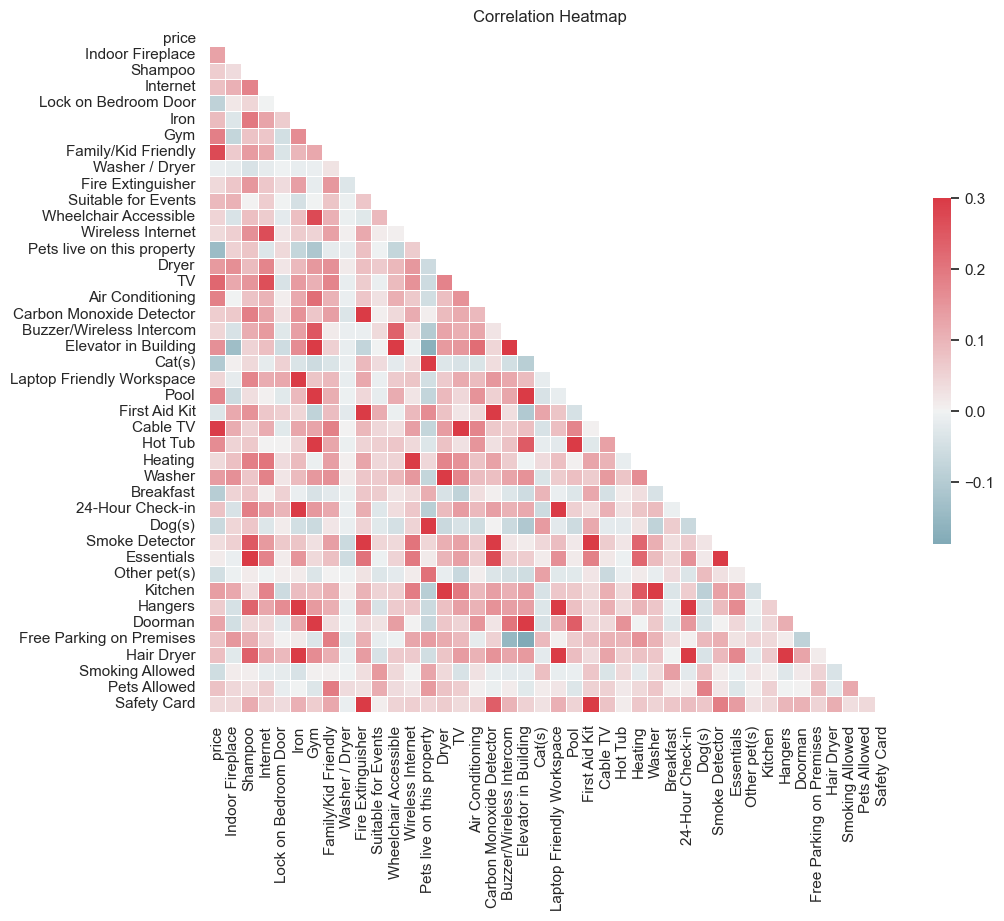

In [28]:
corr_heatmap(list(all_features),False)

In [29]:
dummies_dict.keys()

dict_keys(['host_response_time', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy'])

3 - 

In [30]:
df_final = df_merged.drop(columns = list(dummies_dict.keys())+['date','available','year_month','id'])

In [32]:
X = df_final.drop(columns = 'price')
y = df_final[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Different number of trees
    'criterion': ['squared_error', 'absolute_error'],  # Different criterion options
}

rf  = RandomForestRegressor(n_estimators=100, 
                               criterion='squared_error', 
                               n_jobs=-1)

# Get the best model
rf.fit(X_train, y_train)

# Evaluate on the test set
y_test_preds = rf.predict(X_test)
y_train_preds = rf.predict(X_train)

#calculate scores for the modelb

Random Forest mean squered error train: 177.26, test:195.93
Random Forest R2: 0.98, test:0.98


In [33]:
print('Random Forest mean squered error train: {:.3f}, test:{:.3f}'.format(mean_squared_error(y_train, y_train_preds),mean_squared_error(y_test, y_test_preds)))
print('Random Forest R2: {:.3f}, test:{:.3f}'.format(r2_score(y_train, y_train_preds),r2_score(y_test, y_test_preds)))

Random Forest mean squered error train: 177.265, test:195.927
Random Forest R2: 0.984, test:0.982


Based on these results, we can conclude that the model accounts for 98% of the variation in price. For comparison, we evaluated a simple dummy model that generates predictions by randomly selecting values between the minimum and maximum price range.

In [51]:
min_price = y_train.min()
max_price = y_train.max()

# Create random predictions within the min and max range for both train and test sets
y_train_dummy = np.random.uniform(min_price, max_price, len(y_train))
y_test_dummy = np.random.uniform(min_price, max_price, len(y_test))

# Calculate metrics for the dummy model
mse_train_dummy = mean_squared_error(y_train, y_train_dummy)
mse_test_dummy = mean_squared_error(y_test, y_test_dummy)
r2_train_dummy = r2_score(y_train, y_train_dummy)
r2_test_dummy = r2_score(y_test, y_test_dummy)

# Print results for the dummy model
print(f"Dummy Model MSE (Train): {mse_train_dummy:.3f}, MSE (Test): {mse_test_dummy:.3f}")
print(f"Dummy Model R² (Train): {r2_train_dummy:.3f}, R² (Test): {r2_test_dummy:.3f}")

Dummy Model MSE (Train): 713634.772, MSE (Test): 713218.200
Dummy Model R² (Train): -63.362, R² (Test): -64.300


In [47]:

# Get feature importance from the random forest model
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance (descending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ordenar as 15 principais features mais importantes
top_15_features = feature_importance_df.head(15)

# Criar o gráfico de barras horizontal com Plotly
fig = px.bar(
    top_15_features, 
    x='Importance', 
    y='Feature', 
    orientation='h',
    title='Top 15 Feature Importance for RandomForestRegressor',
    labels={'Importance': 'Feature Importance', 'Feature': 'Features'},
    height=600
)

# Inverter a ordem dos eixos para que o mais importante fique no topo
fig.update_layout(yaxis=dict(autorange="reversed"))

# Mostrar o gráfico
fig.show()

With this chart is possible to visualize the importance of each feature in the model, we had already seen that the neighborhoods and monht of the year that the airbnb is rented, we caanse see that other factors like bedrooms, bathrros,
cleaing fee are factores to contribute with the price of an airbnb.